In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


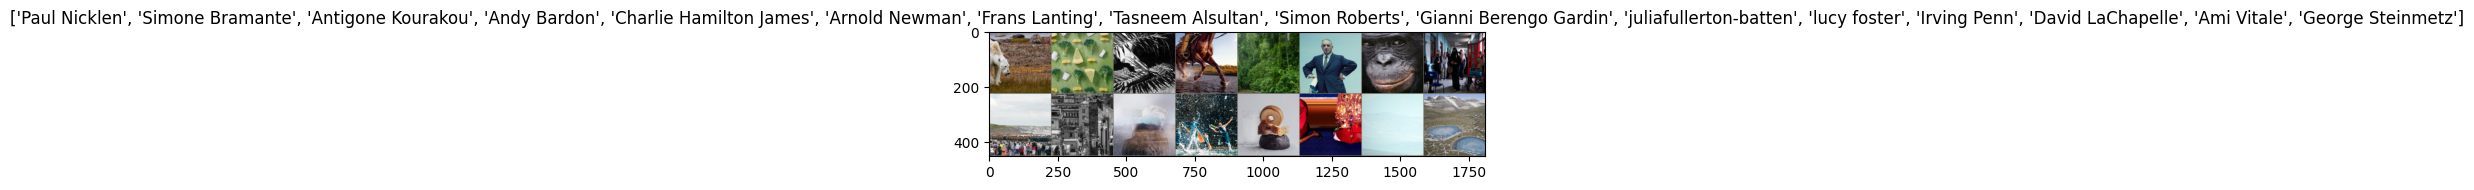

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    #best_model_wts = copy.deepcopy(model_.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 48)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.9MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


 26%|██▌       | 53/205 [11:17<30:45, 12.14s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:18<00:00, 11.80s/it]


train Loss: 3.3735 Acc: 0.1565


100%|██████████| 51/51 [03:19<00:00,  3.90s/it]


test Loss: 2.8343 Acc: 0.2914

Epoch 1/9
----------


 48%|████▊     | 98/205 [19:37<22:19, 12.52s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:44<00:00, 11.92s/it]


train Loss: 2.4317 Acc: 0.3675


100%|██████████| 51/51 [03:15<00:00,  3.83s/it]


test Loss: 2.4185 Acc: 0.3309

Epoch 2/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:54<00:00, 11.97s/it]


train Loss: 1.9684 Acc: 0.4720


100%|██████████| 51/51 [03:16<00:00,  3.86s/it]


test Loss: 2.2522 Acc: 0.3852

Epoch 3/9
----------


 24%|██▍       | 49/205 [09:59<33:18, 12.81s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [41:04<00:00, 12.02s/it]


train Loss: 1.6770 Acc: 0.5424


100%|██████████| 51/51 [03:19<00:00,  3.92s/it]


test Loss: 2.2167 Acc: 0.3889

Epoch 4/9
----------


  3%|▎         | 7/205 [01:30<39:52, 12.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:50<00:00, 11.96s/it]


train Loss: 1.4363 Acc: 0.6043


100%|██████████| 51/51 [03:11<00:00,  3.76s/it]


test Loss: 2.1824 Acc: 0.4148

Epoch 5/9
----------


 92%|█████████▏| 188/205 [37:36<03:26, 12.17s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:49<00:00, 11.95s/it]


train Loss: 1.2938 Acc: 0.6417


100%|██████████| 51/51 [03:13<00:00,  3.79s/it]


test Loss: 2.1841 Acc: 0.4358

Epoch 6/9
----------


 91%|█████████ | 186/205 [37:10<03:44, 11.83s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:42<00:00, 11.91s/it]


train Loss: 1.1581 Acc: 0.6769


100%|██████████| 51/51 [03:17<00:00,  3.87s/it]


test Loss: 2.1685 Acc: 0.4617

Epoch 7/9
----------


 45%|████▍     | 92/205 [18:36<23:35, 12.53s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:58<00:00, 11.99s/it]


train Loss: 0.9168 Acc: 0.7556


100%|██████████| 51/51 [03:19<00:00,  3.90s/it]


test Loss: 1.9635 Acc: 0.5000

Epoch 8/9
----------


 71%|███████   | 145/205 [29:07<12:02, 12.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [41:01<00:00, 12.01s/it]


train Loss: 0.8526 Acc: 0.7718


100%|██████████| 51/51 [03:11<00:00,  3.75s/it]


test Loss: 2.0591 Acc: 0.4951

Epoch 9/9
----------


 37%|███▋      | 76/205 [15:18<24:43, 11.50s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [40:52<00:00, 11.96s/it]


train Loss: 0.8106 Acc: 0.7951


100%|██████████| 51/51 [03:08<00:00,  3.70s/it]

test Loss: 1.9683 Acc: 0.4877

Training complete in 440m 51s
Best test Acc: 0.500000


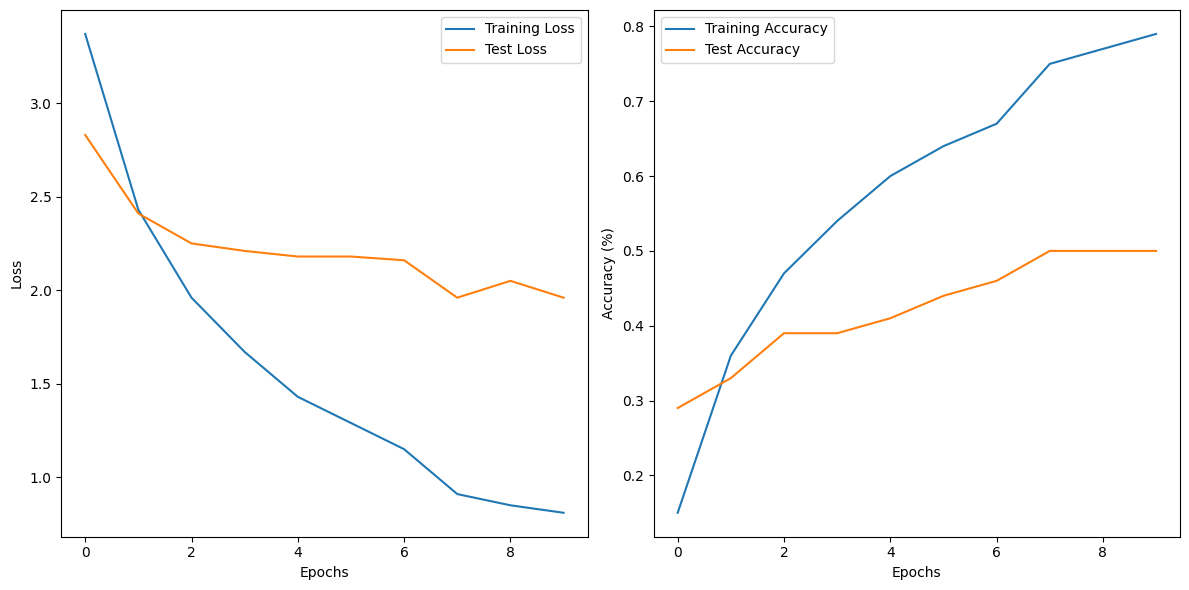

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.37,2.43,1.96,1.67,1.43,1.29,1.15,0.91,0.85,0.81]
test_losses = [2.83,2.41,2.25,2.21,2.18,2.18,2.16,1.96,2.05,1.96]
training_accuracies = [0.15,0.36,0.47,0.54,0.60,0.64,0.67,0.75,0.77,0.79]
test_accuracies = [0.29,0.33,0.39,0.39,0.41,0.44,0.46,0.50,0.50,0.50]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


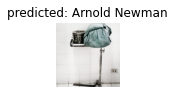

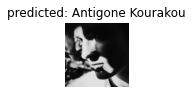

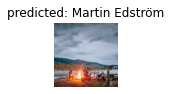

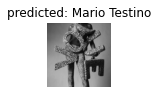

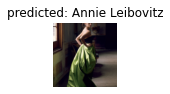

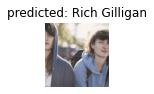

In [ ]:
visualize_model(model_ft)

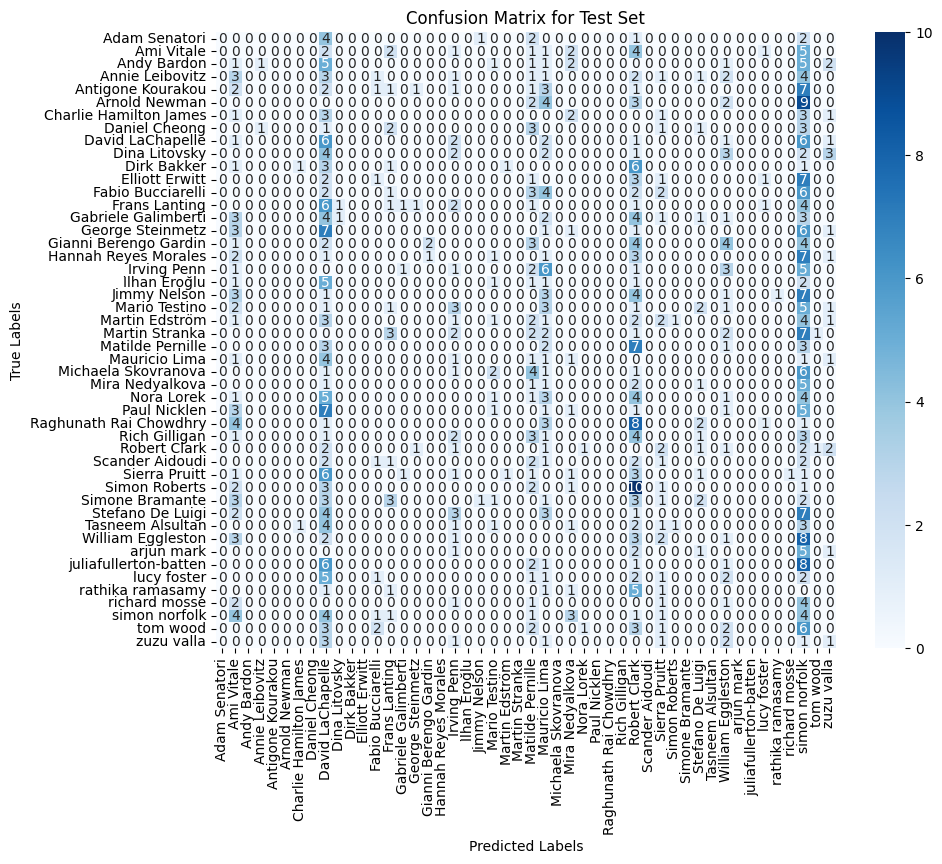

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy

def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save confusion matrix to a file
    np.savetxt("resnet50_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_ft)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet50_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet50.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           0.0    0.0  10.0  800.0   0.000000  0.000000  0.000000
Ami Vitale              0.0   53.0  19.0  738.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    2.0  20.0  788.0   0.000000  0.000000  0.000000
Antigone Kourakou       0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Arnold Newman           0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Charlie Hamilton James  0.0    2.0  11.0  797.0   0.000000  0.000000  0.000000
Daniel Cheong           0.0    0.0  12.0  798.0   0.000000  0.000000  0.000000
David LaChapelle        6.0  132.0  14.0  658.0   0.043478  0.300000  0.075949
Dina Litovsky           0.0    2.0  17.0  791.0   0.000000  0.000000  0.000000
Dirk Bakker        

<Figure size 2200x1000 with 0 Axes>

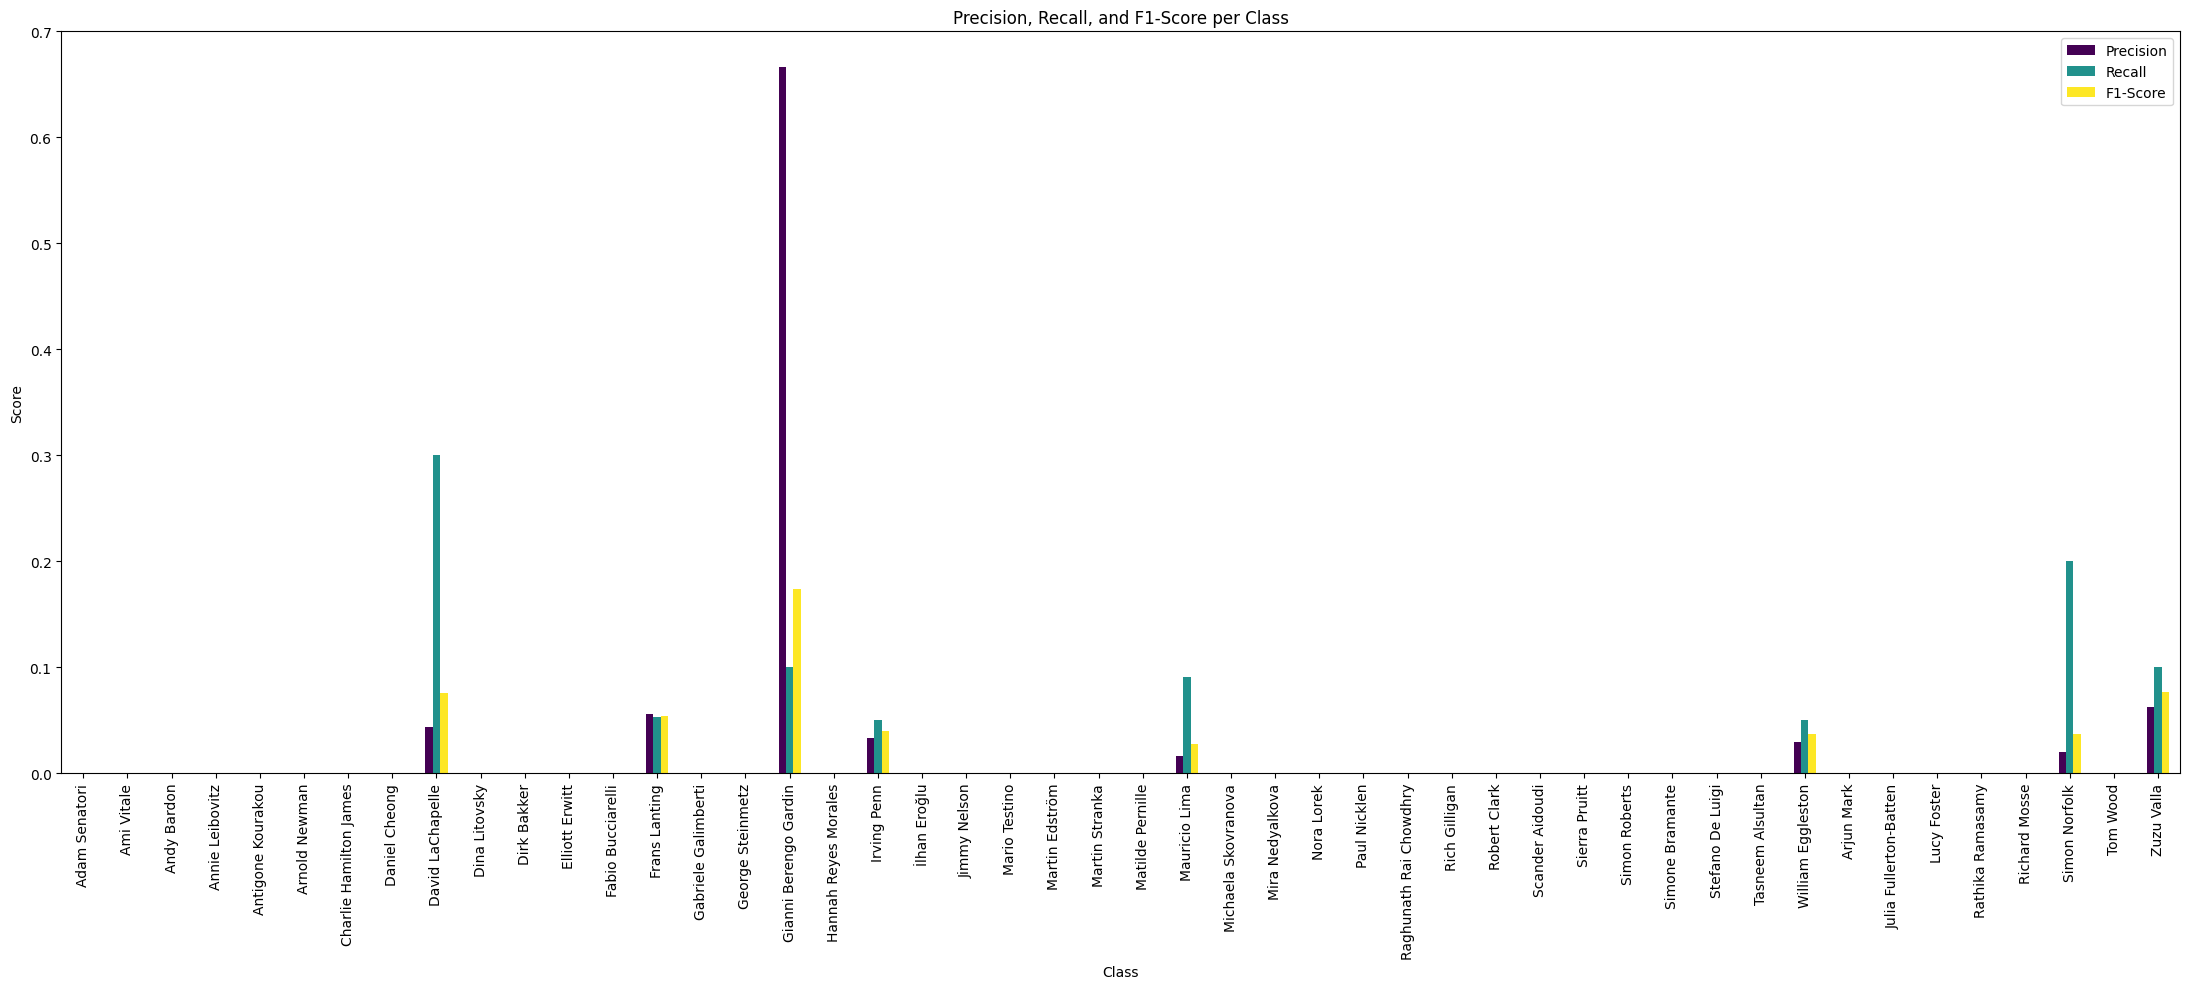

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 48)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 17%|█▋        | 35/205 [02:19<10:27,  3.69s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [12:59<00:00,  3.80s/it]


train Loss: 3.5682 Acc: 0.1188


100%|██████████| 51/51 [02:48<00:00,  3.30s/it]


test Loss: 3.3024 Acc: 0.1889

Epoch 1/9
----------


 76%|███████▌  | 155/205 [09:55<03:05,  3.72s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [12:59<00:00,  3.80s/it]


train Loss: 2.9760 Acc: 0.2701


100%|██████████| 51/51 [02:50<00:00,  3.35s/it]


test Loss: 2.9824 Acc: 0.2481

Epoch 2/9
----------


 94%|█████████▍| 193/205 [12:21<00:45,  3.77s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:00<00:00,  3.81s/it]


train Loss: 2.6380 Acc: 0.3556


100%|██████████| 51/51 [02:49<00:00,  3.32s/it]


test Loss: 2.8113 Acc: 0.2815

Epoch 3/9
----------


 28%|██▊       | 57/205 [03:44<09:28,  3.84s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:04<00:00,  3.83s/it]


train Loss: 2.4215 Acc: 0.3899


100%|██████████| 51/51 [02:53<00:00,  3.39s/it]


test Loss: 2.7320 Acc: 0.2914

Epoch 4/9
----------


 67%|██████▋   | 138/205 [08:57<04:36,  4.13s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:05<00:00,  3.83s/it]


train Loss: 2.2655 Acc: 0.4282


100%|██████████| 51/51 [02:49<00:00,  3.31s/it]


test Loss: 2.6347 Acc: 0.3037

Epoch 5/9
----------


 75%|███████▌  | 154/205 [09:57<03:09,  3.72s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:09<00:00,  3.85s/it]


train Loss: 2.1553 Acc: 0.4551


100%|██████████| 51/51 [02:49<00:00,  3.32s/it]


test Loss: 2.5569 Acc: 0.3284

Epoch 6/9
----------


 86%|████████▌ | 176/205 [11:19<01:50,  3.81s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:04<00:00,  3.83s/it]


train Loss: 2.0857 Acc: 0.4677


100%|██████████| 51/51 [02:48<00:00,  3.30s/it]


test Loss: 2.5434 Acc: 0.3259

Epoch 7/9
----------


 25%|██▍       | 51/205 [03:21<09:37,  3.75s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:05<00:00,  3.83s/it]


train Loss: 1.9575 Acc: 0.5051


100%|██████████| 51/51 [02:48<00:00,  3.31s/it]


test Loss: 2.4929 Acc: 0.3506

Epoch 8/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:06<00:00,  3.84s/it]


train Loss: 1.9683 Acc: 0.5020


100%|██████████| 51/51 [02:54<00:00,  3.42s/it]


test Loss: 2.4775 Acc: 0.3481

Epoch 9/9
----------


 11%|█         | 22/205 [01:31<11:57,  3.92s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [13:07<00:00,  3.84s/it]


train Loss: 1.9319 Acc: 0.5204


100%|██████████| 51/51 [02:48<00:00,  3.31s/it]


test Loss: 2.4942 Acc: 0.3506

Training complete in 159m 4s
Best test Acc: 0.350617


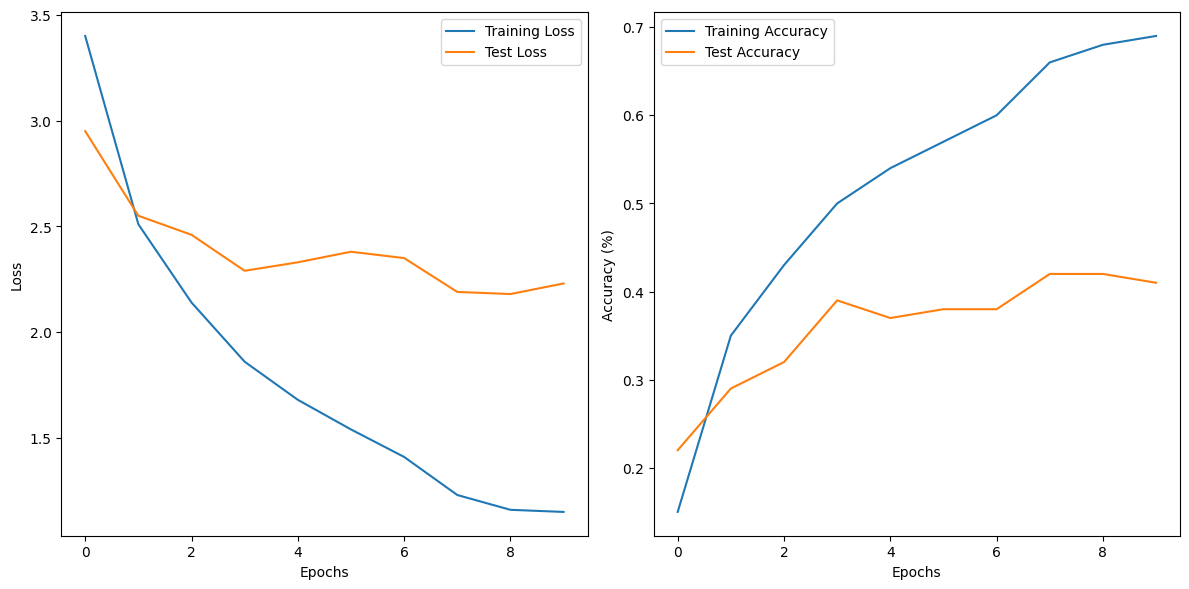

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.56,2.97,2.63,2.42,2.26,2.15,2.08,1.95,1.96,1.93]
test_losses = [3.30,2.98,2.81,2.73,2.63,2.55,2.54,2.49,2.47,2.49]
training_accuracies = [0.11,0.27,0.35,0.38,0.42,0.45,0.46,0.50,0.50,0.52]
test_accuracies = [0.18,0.24,0.28,0.29,0.30,0.32,0.35,0.34,0.35]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


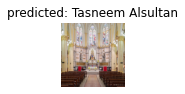

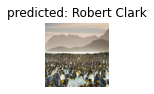

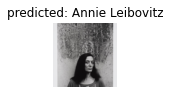

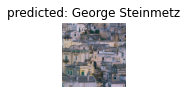

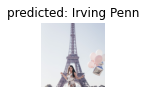

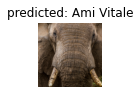

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


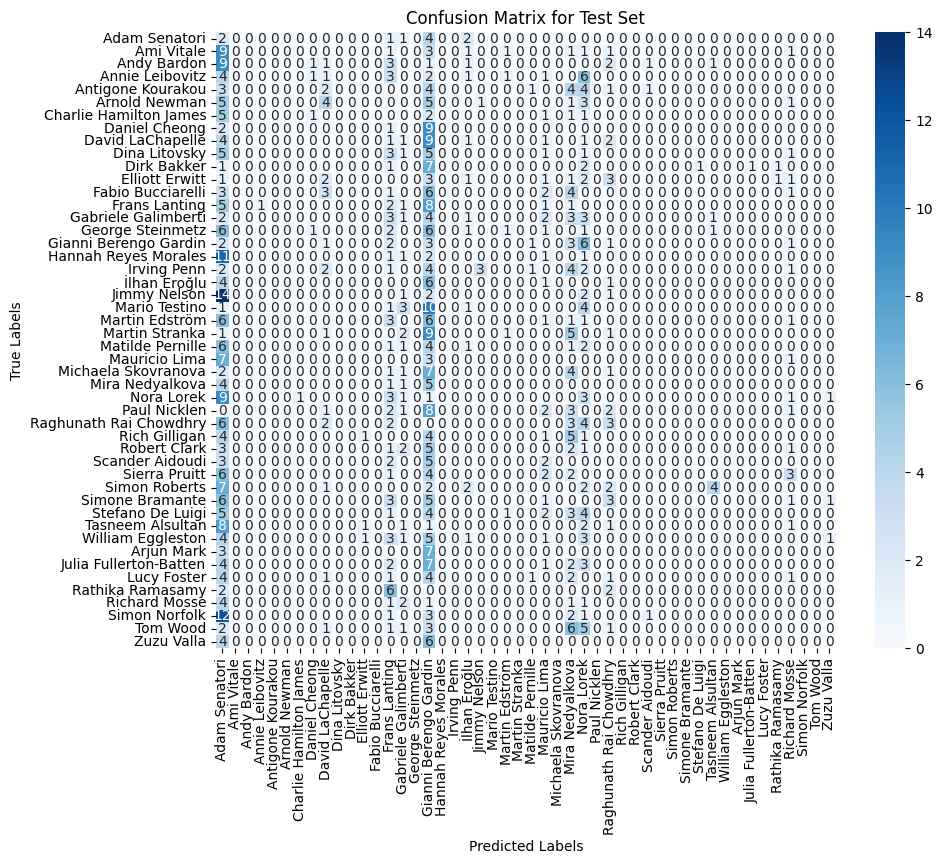

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    np.savetxt("resnet50_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_conv)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet50_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet34.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           2.0  220.0   8.0  580.0   0.009009  0.200000  0.017241
Ami Vitale              0.0    0.0  19.0  791.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    1.0  20.0  789.0   0.000000  0.000000  0.000000
Antigone Kourakou       0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Arnold Newman           0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Charlie Hamilton James  0.0    1.0  11.0  798.0   0.000000  0.000000  0.000000
Daniel Cheong           0.0    4.0  12.0  794.0   0.000000  0.000000  0.000000
David LaChapelle        0.0   23.0  20.0  767.0   0.000000  0.000000  0.000000
Dina Litovsky           0.0    0.0  17.0  793.0   0.000000  0.000000  0.000000
Dirk Bakker        

<Figure size 2200x1000 with 0 Axes>

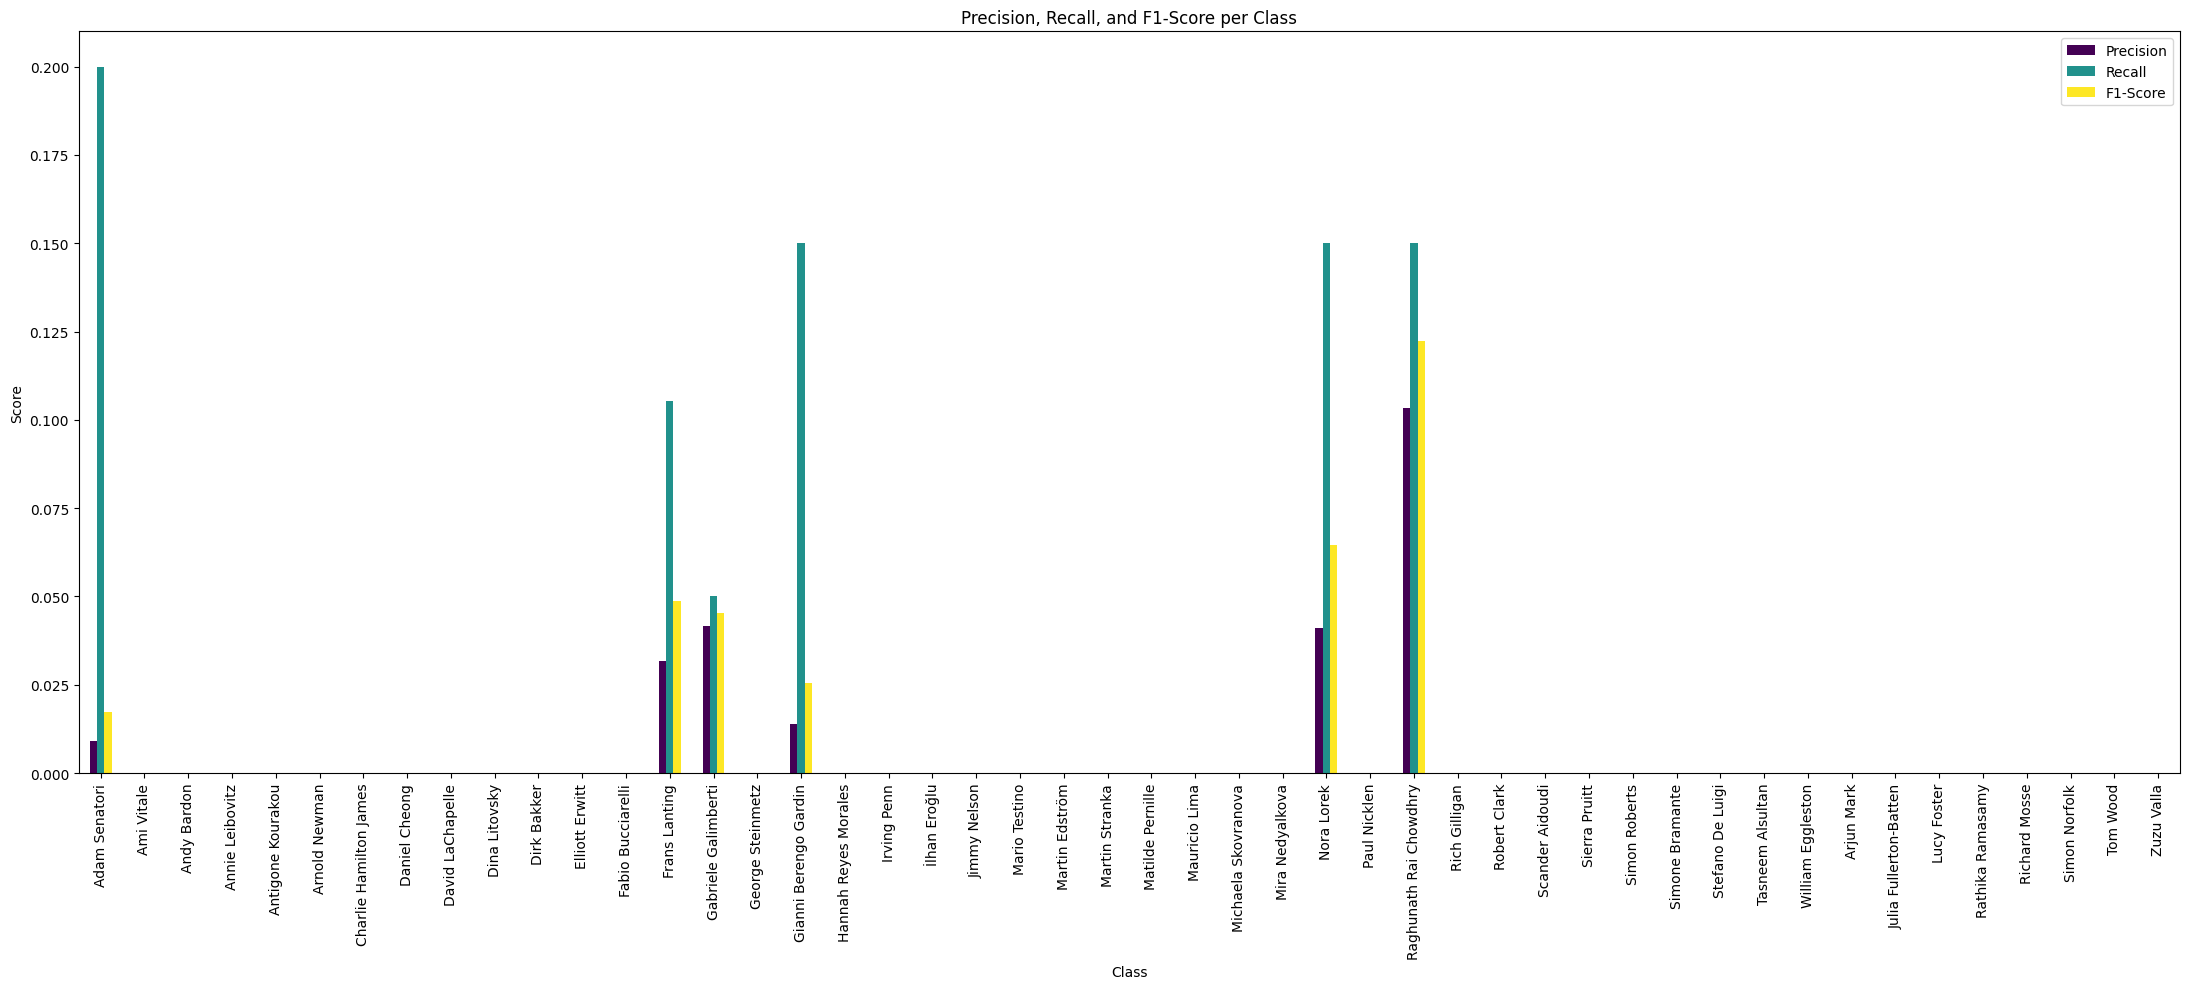

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
